In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yonaadehermawan","key":"376c7d0fa449c9d190796dbba24ba41b"}'}

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d shashwatwork/consume-complaints-dataset-fo-nlp
!ls

 76% 15.0M/19.8M [00:00<00:00, 33.5MB/s]
100% 19.8M/19.8M [00:00<00:00, 57.2MB/s]
consume-complaints-dataset-fo-nlp.zip  kaggle.json  sample_data


In [6]:
# Ekstraksi pada file zip sebelumnya
import zipfile
local_zip = '/content/consume-complaints-dataset-fo-nlp.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import pandas as pd
df = pd.read_csv('/content/complaints_processed.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.astype(str, copy= True)
df.tail()

,product,narrative
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


In [24]:
category = pd.get_dummies(df['product'])
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='product')
df_baru.tail()

,narrative,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
162416,name,0,0,1,0,0
162417,name,1,0,0,0,0
162418,name,0,0,1,0,0
162419,name,1,0,0,0,0
162420,name,0,1,0,0,0


In [25]:
from sklearn.model_selection import train_test_split
pesan = df_baru['narrative'].values
label = df_baru[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values
pesan_latih, pesan_test, label_latih, label_test = train_test_split(pesan, label, test_size=0.2)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=250, oov_token='x')
tokenizer.fit_on_texts(pesan_latih) 
tokenizer.fit_on_texts(pesan_test)

sekuens_latih = tokenizer.texts_to_sequences(pesan_latih)
sekuens_test = tokenizer.texts_to_sequences(pesan_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [27]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2500, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
num_epochs = 30

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(padded_latih, label_latih, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), callbacks = [callbacks], verbose=2)

Epoch 1/30
4061/4061 - 319s - loss: 0.7010 - accuracy: 0.7428 - val_loss: 0.5921 - val_accuracy: 0.7963
Epoch 2/30
4061/4061 - 320s - loss: 0.5565 - accuracy: 0.8112 - val_loss: 0.5072 - val_accuracy: 0.8302
Epoch 3/30
4061/4061 - 323s - loss: 0.5354 - accuracy: 0.8154 - val_loss: 0.4882 - val_accuracy: 0.8335
Epoch 4/30
4061/4061 - 321s - loss: 0.4855 - accuracy: 0.8305 - val_loss: 0.4570 - val_accuracy: 0.8392
Epoch 5/30
4061/4061 - 321s - loss: 0.4504 - accuracy: 0.8409 - val_loss: 0.4332 - val_accuracy: 0.8447
Epoch 6/30
4061/4061 - 321s - loss: 0.4343 - accuracy: 0.8452 - val_loss: 0.4286 - val_accuracy: 0.8469
Epoch 7/30
4061/4061 - 321s - loss: 0.4225 - accuracy: 0.8485 - val_loss: 0.4201 - val_accuracy: 0.8475
Epoch 8/30
4061/4061 - 321s - loss: 0.4126 - accuracy: 0.8514 - val_loss: 0.4185 - val_accuracy: 0.8496
Epoch 9/30
4061/4061 - 321s - loss: 0.4032 - accuracy: 0.8558 - val_loss: 0.4174 - val_accuracy: 0.8477
Epoch 10/30
4061/4061 - 320s - loss: 0.3952 - accuracy: 0.8580 -

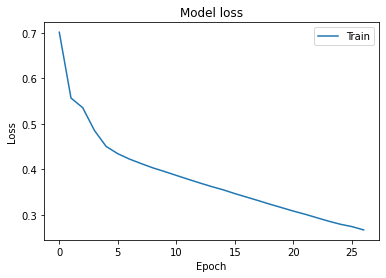

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

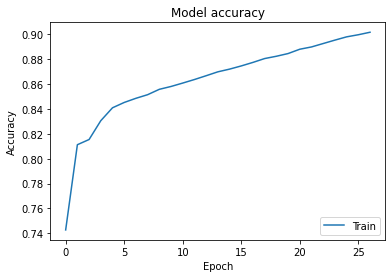

In [30]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()